In [ ]:
import dill
import struct
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# tensorboard --logdir=/opt/logs --port=6007
writer = SummaryWriter(log_dir="/opt/logs/task2-mnist-torch", flush_secs=30)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [ ]:
# 用于适配interview接口
class MNIST_Net(nn.Module):
    @staticmethod
    def image_data(file_name):
        with open(file_name, "rb") as f:
            buffer = f.read(16)
            magic, num, rows, cols = struct.unpack(">iiii", buffer)
            buffer = f.read(rows * cols * num)
            data = np.frombuffer(buffer, dtype=np.uint8)
            data = data.reshape(num, rows, cols)
        return data

    @staticmethod
    def label_data(file_name):
        with open(file_name, "rb") as f:
            buffer = f.read(8)
            magic, num = struct.unpack(">ii", buffer)
            buffer = f.read(num)
            data = np.frombuffer(buffer, dtype=np.uint8)
            data = data.reshape(num, 1)
        return data

    @staticmethod
    def one_hot(labels, num_classes):
        one_hot_labels = np.zeros((len(labels), num_classes))
        for i in range(len(labels)):
            one_hot_labels[i, labels[i]] = 1
        return one_hot_labels

    def interview(self, eval_datafile_path, device):
        eval_images = self.image_data(eval_datafile_path[0])
        eval_labels = self.label_data(eval_datafile_path[1])
        eval_images = eval_images.reshape(-1, 1, 28, 28)
        eval_labels = self.one_hot(eval_labels, 10)
        eval_images = torch.from_numpy(np.array(eval_images, copy=True)).float()
        eval_labels = torch.from_numpy(np.array(eval_labels, copy=True)).float()
        eval_images, eval_labels = eval_images.to(device), eval_labels.to(device)

        self.eval()
        with torch.no_grad():
            pred = self.forward(eval_images)
            accuracy = torch.sum(torch.argmax(pred, dim=1) == torch.argmax(eval_labels, dim=1)).item()
        return accuracy / len(eval_labels) * 100

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # (1,28,28) -> (32,28,28) -> (32,14,14)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # (32,14,14) -> (64,14,14) -> (64,7,7)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
        )

        # 权重初始化
        for m in self.net.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

(60000, 28, 28) (60000, 1)


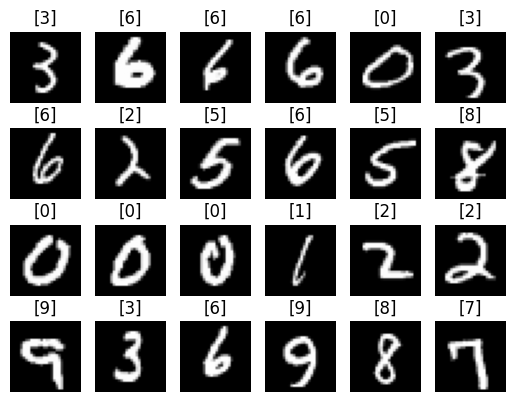

In [3]:
# 读取文件数据
images = MNIST_Net.image_data("/opt/data/mnist_testdata/train-images.idx3-ubyte")
labels = MNIST_Net.label_data("/opt/data/mnist_testdata/train-labels.idx1-ubyte")
print(images.shape, labels.shape)

# 随机打乱数据
np.random.seed(0)
indices = np.random.permutation(len(images))
images = images[indices]
labels = labels[indices]

for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.title(labels[i])
    plt.axis("off")
plt.show()

In [4]:
# 分割训练集与验证集 (4:1)
split = int(len(images) * 0.8)
train_images, valid_images = images[:split], images[split:]
train_labels, valid_labels = labels[:split], labels[split:]

In [ ]:
# 添加图片通道
height, width = images.shape[1], images.shape[2]
train_images = train_images.reshape(-1, 1, height, width)
valid_images = valid_images.reshape(-1, 1, height, width)

# 独热标签数据
train_labels = MNIST_Net.one_hot(train_labels, 10)
valid_labels = MNIST_Net.one_hot(valid_labels, 10)

print(train_images.shape, valid_images.shape)
print(train_labels.shape, valid_labels.shape)

(48000, 1, 28, 28) (12000, 1, 28, 28)
(48000, 10) (12000, 10)


In [6]:
# 转换图像数据
train_images = torch.from_numpy(train_images).float()  # (48000, 1, 28, 28)
valid_images = torch.from_numpy(valid_images).float()  # (12000, 1, 28, 28)

# 转换标签数据
train_labels = torch.from_numpy(train_labels).float()  # (48000, 10)
valid_labels = torch.from_numpy(valid_labels).float()  # (12000, 10)

train_dataset = TensorDataset(train_images, train_labels)
valid_dataset = TensorDataset(valid_images, valid_labels)
train_size, test_size = len(train_dataset), len(valid_dataset)

In [ ]:
epoch_count = 0  # 总训练轮数
best_accuracy = 0  # 最佳准确率
model_path = "task2-mnist-torch.pkl"  # 模型保存路径

batch_size = 128  # 批处理大小
initial_lr = 1e-3  # 初始学习率
lr_patience = 10  # 学习率容忍次数
lr_factor = 0.5  # 学习率衰减因子

worse_count = 0  # 连续无增长计数
worse_tolerance = 20  # 无增长容忍次数

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size, True)
valid_dataloader = DataLoader(valid_dataset, batch_size, False)

model = MNIST_Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=lr_patience, factor=lr_factor)

In [ ]:
max_epochs = 200
pbar = tqdm(range(max_epochs))
for i in pbar:
    train_loss, test_loss, accuracy = 0, 0, 0

    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        for X, y in valid_dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            accuracy += torch.sum(torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)).item()

    epoch_count += 1
    train_loss /= train_size
    test_loss /= test_size
    accuracy = accuracy / test_size * 100
    scheduler.step(test_loss)

    if accuracy > best_accuracy:
        worse_count = 0
        best_accuracy = accuracy
        with open(model_path, "wb") as f:
            dill.dump(model, f)
    else:
        worse_count += 1
        if worse_count == worse_tolerance:
            print(f"模型连续{worse_tolerance}次无提升，提前终止训练")
            break

    writer.add_scalar("train_loss", train_loss, i)
    writer.add_scalar("test_loss", test_loss, i)
    writer.add_scalar("accuracy", accuracy, i)
    writer.add_scalar("learning_rate", optimizer.param_groups[0]["lr"], i)
    pbar.set_postfix(lr=f"{optimizer.param_groups[0]["lr"]:.0e}", train_loss=f"{train_loss:.2e}", test_loss=f"{test_loss:.2e}", accuracy=f"{accuracy:.2f}%", best_accuracy=f"{best_accuracy:.2f}%")

print("模型架构:", model)
print("模型参数:", sum(p.numel() for p in model.parameters()))
print("保存路径:", model_path)
print("最佳训练轮数:", epoch_count - worse_tolerance)
print("最佳准确率:", best_accuracy)

 32%|███▎      | 65/200 [01:17<02:40,  1.19s/it, accuracy=99.24%, best_accuracy=99.28%, lr=6e-05, test_loss=6.76e-04, train_loss=2.27e-05]

模型连续20次无提升，提前终止训练
模型架构: MNIST_Net(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)
模型参数: 421642
保存路径: task2-mnist-torch.pth
最佳训练轮数: 46
最佳准确率: 99.275
